In [6]:
#!/usr/bin/env python3
import tensorflow as tf

raw_dataset = tf.data.TFRecordDataset(["tfrecords/dichasus-0053.tfrecords", "tfrecords/dichasus-0054.tfrecords", "tfrecords/dichasus-0055.tfrecords", "tfrecords/dichasus-0056.tfrecords", "tfrecords/dichasus-0057.tfrecords"])

feature_description = {
	"csi": tf.io.FixedLenFeature([], tf.string, default_value = ''),
	"pos-lidar": tf.io.FixedLenFeature([], tf.string, default_value = ''),
	"rot": tf.io.FixedLenFeature([], tf.float32, default_value = 0),
	"snr": tf.io.FixedLenFeature([], tf.string, default_value = ''),
	"time": tf.io.FixedLenFeature([], tf.float32, default_value = 0),
}
			
def record_parse_function(proto):
	record = tf.io.parse_single_example(proto, feature_description)

	# Channel coefficients for all antennas, over all subcarriers, real and imaginary parts
	csi = tf.ensure_shape(tf.io.parse_tensor(record["csi"], out_type = tf.float32), (32, 1024, 2))

	# Position of transmitter determined by vacuum robot LIDAR, in meters (X / Y coordinates)
	pos_lidar = tf.ensure_shape(tf.io.parse_tensor(record["pos-lidar"], out_type = tf.float64), (2))

	# Rotation of robot relative to its initial parking position, in radians
	rot = tf.ensure_shape(record["rot"], ())

	# Signal-to-Noise ratio estimates for all antennas
	snr = tf.ensure_shape(tf.io.parse_tensor(record["snr"], out_type = tf.float32), (32))

	# Timestamp since start of measurement campaign, in seconds
	time = tf.ensure_shape(record["time"], ())

	return csi, pos_lidar, rot, snr, time
			
dataset = raw_dataset.map(record_parse_function, num_parallel_calls = tf.data.experimental.AUTOTUNE)

# Optional: Cache dataset in RAM for faster training
dataset = dataset.cache()

In [7]:
for x in dataset:
    print("CSI shape:", x[0].numpy())
    print("Position (GNSS):", x[1].numpy())
    print("SNR:", x[2].numpy())
    print("Standard Deviation (GNSS):", x[3].numpy())
    print("Time:", x[4].numpy())
    break

CSI shape: [[[ 4.677066    5.6480703 ]
  [ 4.847598    5.4856462 ]
  [ 4.838405    5.524256  ]
  ...
  [ 4.992615    5.503038  ]
  [ 4.9786806   5.5077133 ]
  [ 4.964582    5.5506005 ]]

 [[-4.335247   -0.6367858 ]
  [-4.3260746  -0.51643324]
  [-4.3296833  -0.5110897 ]
  ...
  [-4.4847803  -0.48019722]
  [-4.467213   -0.47334757]
  [-4.4673877  -0.49514312]]

 [[-0.456782   -3.9246633 ]
  [-0.6060356  -3.8824916 ]
  [-0.6376779  -3.9059012 ]
  ...
  [-0.5795499  -3.9791732 ]
  [-0.5913298  -3.9797091 ]
  [-0.5953056  -3.975963  ]]

 ...

 [[ 3.8970525   1.2842767 ]
  [ 3.978285    1.0757    ]
  [ 4.0061326   1.0815977 ]
  ...
  [ 3.900131    1.250023  ]
  [ 3.913517    1.2190633 ]
  [ 3.9695144   1.1905873 ]]

 [[-2.3095734  -2.8977933 ]
  [-2.3791945  -2.854156  ]
  [-2.358918   -2.895447  ]
  ...
  [-2.561728   -2.7974913 ]
  [-2.507762   -2.7930186 ]
  [-2.4648798  -2.8466678 ]]

 [[-4.575502   -2.5826828 ]
  [-4.6484637  -2.3990104 ]
  [-4.6935163  -2.4043748 ]
  ...
  [-4.6796784

2025-07-30 21:46:06.068429: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [12]:
ground_truth = dataset.map(lambda csi, pos_lidar, rot,snr, time: pos_lidar)

In [13]:
csi = dataset.map(lambda csi, pos_lidar, rot,snr, time: csi)

In [14]:
csi._shape_invariant_to_type_spec

<bound method CompositeTensor._shape_invariant_to_type_spec of <_MapDataset element_spec=TensorSpec(shape=(32, 1024, 2), dtype=tf.float32, name=None)>>

In [15]:
for x in ground_truth:
    print("Ground Truth Position (GNSS):", x.numpy())
    break

Ground Truth Position (GNSS): [ 0.006 -0.066]


2025-07-30 21:47:37.441793: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [16]:
# making the dataset into a numpy array
import numpy as np

def dataset_to_numpy(dataset):
    numpy_arrays = []
    for x in dataset:
        numpy_arrays.append(x.numpy())
    return np.array(numpy_arrays)
ground_truth_np = dataset_to_numpy(ground_truth)

In [17]:
ground_truth_np.shape

(26161, 2)

In [18]:
csi_np = dataset_to_numpy(csi)

In [19]:
csi_np.shape

(26161, 32, 1024, 2)

In [20]:
csi_real= csi_np[:, :, :,0]
csi_imag = csi_np[:, :, :,1]

In [21]:
csi_real.shape, csi_imag.shape

((26161, 32, 1024), (26161, 32, 1024))

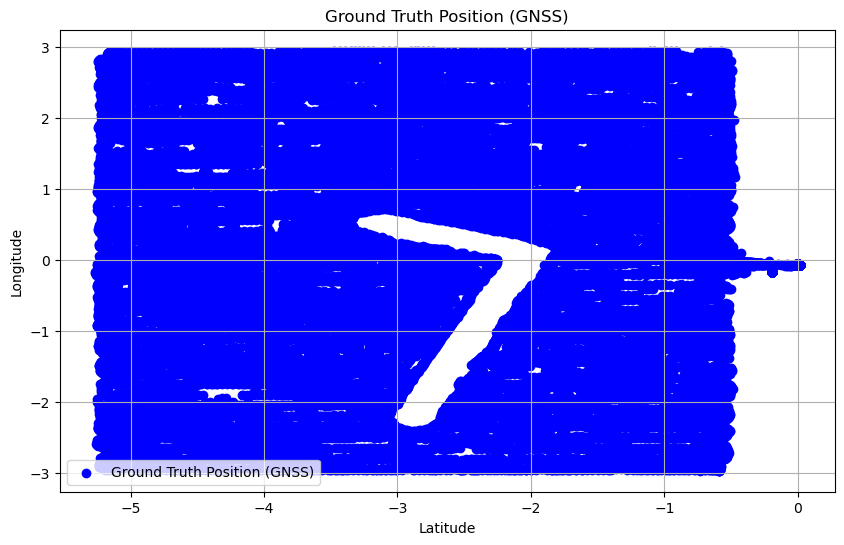

In [22]:
import matplotlib.pyplot as plt

# Plotting the ground truth positions
plt.figure(figsize=(10, 6))
plt.scatter(ground_truth_np[:, 0], ground_truth_np[:, 1], c='blue', label='Ground Truth Position (GNSS)')
plt.title('Ground Truth Position (GNSS)')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()
plt.grid()
plt.show()

In [42]:
import numpy as np
from scipy.special import softmax

def build_grid(grid_size=30, space_bounds=None):
    (xmin, xmax), (ymin, ymax) = space_bounds
    x_lin = np.linspace(xmin, xmax, grid_size)
    y_lin = np.linspace(ymin, ymax, grid_size)
        
    xv, yv = np.meshgrid(x_lin, y_lin)
    grid_points = np.stack([xv.ravel(), yv.ravel()], axis=1)
    return grid_points

def compute_soft_probability_maps(positions, grid_points, temperature=.1):
    N = positions.shape[0]
    K = grid_points.shape[0]
    dists = np.linalg.norm(positions[:, np.newaxis, :] - grid_points[np.newaxis, :, :], axis=2)
    sim_scores = -dists / temperature
    prob_maps = softmax(sim_scores, axis=1)
    return prob_maps

def estimate_positions_from_maps(prob_maps, grid_points):
    return np.matmul(prob_maps, grid_points)

def generate_all_probability_maps(positions, grid_size=30, temperature=.1):
    x_min, x_max = positions[:, 0].min(), positions[:, 0].max()
    y_min, y_max = positions[:, 1].min(), positions[:, 1].max()
    print("Position bounds:", (x_min, x_max), (y_min, y_max))
    grid_points = build_grid(grid_size, space_bounds=((x_min, x_max), (y_min, y_max)))
    print("Grid points shape:", grid_points.shape)
    prob_maps = compute_soft_probability_maps(positions, grid_points, temperature=temperature)

    est_locations = estimate_positions_from_maps(prob_maps, grid_points)

    return prob_maps, est_locations, grid_points